# Predicting Bad Loans Using Lending Club Data

### Contents

 1. Objectives
 2. Data Dictionary
 3. Data Cleaning and Pre-Processing
     1. Loading Data
     2. Data Summary
     3. Data Cleaning
         1. Find missing values
         2. Find unique observations with rare values
         3. Identify correlated predictors
     4. Data Pre-Processing for machine Learning tasks  
         1. Converting each variable to correct type
         2. re-scale(normalize) numerical variables
         3. Creating dummy variables for categorical variables
         4. Train, Validation and Test Data Split
 4. Model Selection and Evaluation
     2. Neural Network(Deep Learning)
     3. Naive Bayes
     4. Random Forest
     6. Gradient Boosting Machine
     1. Generalized Linear Model
     6. Model Performance Comparison
 5. Summary
 6. Reference

## 1. Objectives

Using lending club's historical data to identify bad loans

## 2. Data DIctionary

[Lending club loan data](https://raw.githubusercontent.com/h2oai/h2o-tutorials/master/training/data/loan.csv) with variables:

| Variables| Description |
|:--:|:---|
| loan_amnt|The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.|
|term | The number of payments on the loan. Values are in months and can be either 36 or 60.|
|int_rate |Interest Rate on the loan|
|emp_length |Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.|
| home_ownership|The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.|
|annual_inc | The self-reported annual income provided by the borrower during registration.|
|purpose |A category provided by the borrower for the loan request. |
| addr_state|borrower's state  |
|dti | A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.|
|delinq_2yrs | The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years|
|revol_util |Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.|
|total_acc |The total number of credit lines currently in the borrower's credit file|
| bad_loan|Result we want to predict, is the loan a bad loan? |
|longest_credit_length | longest credit length|
| verification_status| Indicates if the co-borrowers' joint income was verified by LC, not verified, or if the income source was verified|


In [37]:
# Load libraries
library(tidyverse) # for data manipulation and ploting
library(caret) # for machine learning and data pre-processing
library(corrplot) # correlation plot
library(stringr) # for string manipulation
library(h2o) # fo machine learning

## 3.Data Cleaning and Pre-Processing
### 3.A. Loading Data

In [2]:
lending_data <- read.csv("https://raw.githubusercontent.com/h2oai/app-consumer-loan/master/data/loan.csv")

### 3.B.Data Summary and Exploration

In [3]:
#glimpse at data structure
glimpse(lending_data)
#View data summary
summary(lending_data)

Observations: 163,987
Variables: 15
$ loan_amnt             <int> 5000, 2500, 2400, 10000, 5000, 3000, 5600, 53...
$ term                  <fct> 36 months, 60 months, 36 months, 36 months, 3...
$ int_rate              <dbl> 10.65, 15.27, 15.96, 13.49, 7.90, 18.64, 21.2...
$ emp_length            <int> 10, 0, 10, 10, 3, 9, 4, 0, 5, 10, 0, 3, 3, 0,...
$ home_ownership        <fct> RENT, RENT, RENT, RENT, RENT, RENT, OWN, RENT...
$ annual_inc            <dbl> 24000.00, 30000.00, 12252.00, 49200.00, 36000...
$ purpose               <fct> credit_card, car, small_business, other, wedd...
$ addr_state            <fct> AZ, GA, IL, CA, AZ, CA, CA, TX, AZ, CA, VA, I...
$ dti                   <dbl> 27.65, 1.00, 8.72, 20.00, 11.20, 5.35, 5.55, ...
$ delinq_2yrs           <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
$ revol_util            <dbl> 83.70, 9.40, 98.50, 21.00, 28.30, 87.50, 32.6...
$ total_acc             <int> 9, 4, 10, 37, 12, 4, 13, 3, 23, 34, 9, 11, 29...
$ bad_loan      

   loan_amnt            term           int_rate       emp_length    
 Min.   :  500   36 months:129950   Min.   : 5.42   Min.   : 0.000  
 1st Qu.: 7000   60 months: 34037   1st Qu.:10.65   1st Qu.: 2.000  
 Median :11325                      Median :13.49   Median : 6.000  
 Mean   :13074                      Mean   :13.72   Mean   : 5.684  
 3rd Qu.:18000                      3rd Qu.:16.32   3rd Qu.:10.000  
 Max.   :35000                      Max.   :26.06   Max.   :10.000  
                                                    NA's   :5804    
  home_ownership    annual_inc                    purpose        addr_state   
 ANY     :    1   Min.   :   1896   debt_consolidation:93261   CA     :28702  
 MORTGAGE:79714   1st Qu.:  45000   credit_card       :30792   NY     :14285  
 NONE    :   30   Median :  61000   other             :10492   TX     :12128  
 OTHER   :  156   Mean   :  71916   home_improvement  : 9872   FL     :11396  
 OWN     :13560   3rd Qu.:  85000   major_purchase   

### 3.C. Data Cleanning
#### 3.C.a. FInd NAs

Before machine learning tasks, we need to find NAs, assess their influence on our final result. And judge how to deal with them: remove them totally, create new variables or impute them.

In [4]:
t(map_dbl(lending_data,~sum(is.na(.x))))

loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status
0,0,0,5804,0,4,0,0,0,29,193,29,0,29,0


We can find some variables contain NA values(We have **163987** observations):

|Variable Name|NA count|Method|
|:---:|--:|:--|
|emp_length | 5804|Remove this variable and create a new variable *is_emp_missing* to indicate whether emp_length is missing |
| annual_inc| 4| median imputation|
| delinq_2yrs|29 |Remove observations |
| revol_util|193 | median imputation|
|total_acc |29 | Remove observations|
|longest_credit_length|29|Remove observations|

We find that observations with NA in delinq_2yrs,total_acc and longest_credit_length columns are the same. It should be bad data, and it's a small amount of our data. So we can safely remove them.  

As for annual_inc and revol_util, we can use mean imputation.  

However, for emp_length, we cannot simply remove it or empute it as we have many observations with empty emp_length. We need to explore it first. After exploration, we found that emp_length is not very predictive for bad loan, instead, whether this variable is missing is predictive. So we create a new variable *is_emp_missing* to indicate whether employment length is missing.

In [5]:
#check if these are the same observations
lending_data %>% 
    mutate(row_number = row_number()) %>% 
    filter(is.na(delinq_2yrs)) %>% 
    select(row_number,delinq_2yrs,revol_util,total_acc,longest_credit_length)

row_number,delinq_2yrs,revol_util,total_acc,longest_credit_length
38949,NA,NA,NA,NA
38950,NA,NA,NA,NA
38959,NA,NA,NA,NA
38972,NA,NA,NA,NA
38980,NA,NA,NA,NA
38983,NA,NA,NA,NA
38994,NA,NA,NA,NA
39009,NA,NA,NA,NA
39014,NA,NA,NA,NA
39015,NA,NA,NA,NA


In [6]:
#remove some NA observations
cleaned_data <- lending_data %>%
    filter(!is.na(delinq_2yrs))

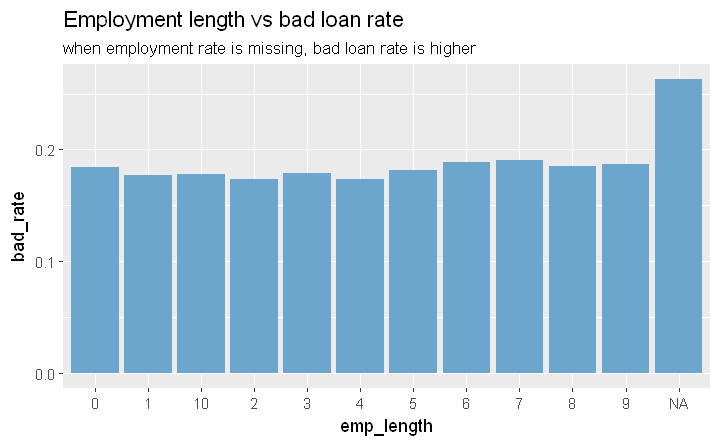

In [7]:
plot_width = 6
options(repr.plot.width= plot_width, repr.plot.height=plot_width * 0.618)
lending_data %>%
    group_by(emp_length) %>%
    summarise(bad_rate = sum(as.numeric(bad_loan))/n()) %>%
    mutate(emp_length = if_else(is.na(emp_length),"NA",as.character(emp_length))) %>%
    arrange(emp_length) %>% 
    ggplot(aes(x = emp_length, y = bad_rate)) +
    geom_col(fill = "skyblue3") +
    labs(title = "Employment length vs bad loan rate", subtitle = "when employment rate is missing, bad loan rate is higher")

#### 3.C.b. Find observations with rare values

We have **163987** observations, by rule of thumb, we need to remove observations appears in less than 0.01% of total observations, in our case, the number is **16**.

So we need to remove this observations in our dataset:

|variables|observations that need to be romoved|
|---|---|
|home_ownership|ANY|
|addr_state|IA,ID,ME,NE|

In [8]:
#### 3.C.b. Find observations with rare values
col_class_fac <- map_chr(lending_data,class) == "factor"
map(lending_data[,col_class_fac],table)
#remove rare observations
cleaned_data <- cleaned_data %>% 
    filter(home_ownership != "ANY" | !(addr_state %in% c("IA","ID","ME","NE")))

$term

36 months 60 months 
   129950     34037 

$home_ownership

     ANY MORTGAGE     NONE    OTHER      OWN     RENT 
       1    79714       30      156    13560    70526 

$purpose

               car        credit_card debt_consolidation        educational 
              2842              30792              93261                418 
  home_improvement              house     major_purchase            medical 
              9872               1245               4686               2029 
            moving              other   renewable_energy     small_business 
              1464              10492                198               3841 
          vacation            wedding 
              1096               1751 

$addr_state

   AK    AL    AR    AZ    CA    CO    CT    DC    DE    FL    GA    HI    IA 
  413  1965  1104  3941 28702  3531  2563   584   445 11396  5189   955    12 
   ID    IL    IN    KS    KY    LA    MA    MD    ME    MI    MN    MO    MS 
    9  6099  1463  13

In [9]:
#remove rare observations
cleaned_data <- cleaned_data %>% 
    filter(!(home_ownership == "ANY" | (addr_state %in% c("IA","ID","ME","NE"))))
#create new column is_emp_missing and remove original one
cleaned_data <- cleaned_data %>%
    mutate(is_emp_missing = if_else(is.na(emp_length),1,0)) %>%
    select(-emp_length)

#### 3.C.c. Indentify correlated predictors

Many models benefit from reduced predictors, we use correlation heatmaps to identify them. In our case, all of our predictors are not correlated, so we can safely skip this part.   
However, int_rate is highly correlated with our prediction, because interest rate is assigned after deciding the risk. So we need to remove interest rate variable.

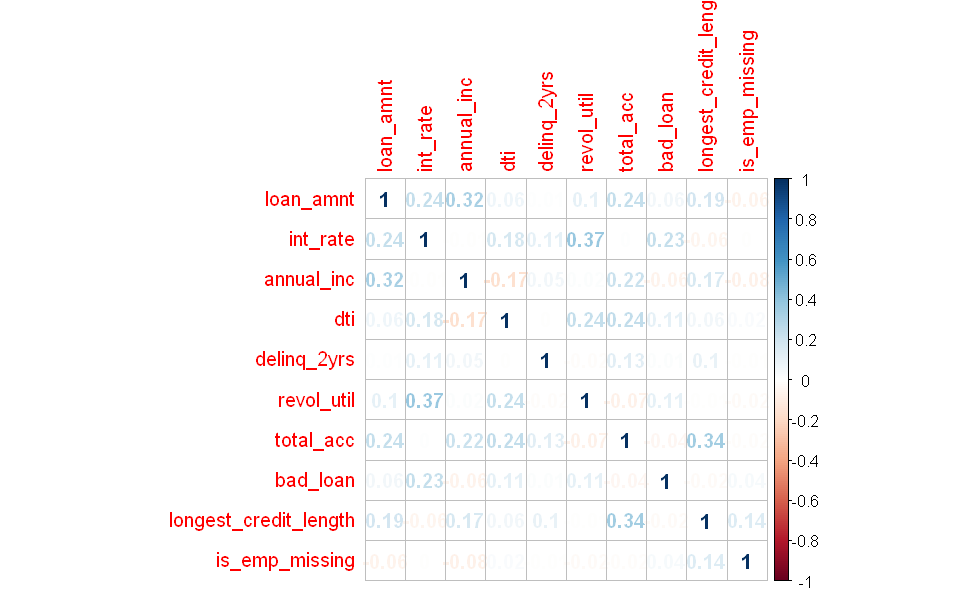

In [10]:
plot_width = 8
options(repr.plot.width= plot_width, repr.plot.height=plot_width * 0.618)
#correlation heatmap with numerical variables
lending_numeric <- cbind(cleaned_data[,map_lgl(cleaned_data,is.numeric)])
corrplot(cor(lending_numeric,use = "complete.obs"),method = "number")
#remove interest rate
cleaned_data<- cleaned_data[,-which("int_rate" == colnames(cleaned_data))]

### 3.D. Data Pre-Processing for machine learning tasks
#### 3.D.a. Converting each variable to correct type

We nned to change *bad_loan* to factor

In [11]:
cleaned_data$bad_loan <- as.factor(cleaned_data$bad_loan)
cleaned_data$addr_state <- factor(cleaned_data$addr_state, levels = unique(cleaned_data$addr_state))

#### 3.D.b. re-scale(normalize) numerical variables

Most algorithms benefits from data with the same scale, especially neural network. So we need to rescale our data.

In [12]:
processed_values <- preProcess(cleaned_data, method = c("center", "scale","medianImpute"))
data_transformed <- predict(processed_values, cleaned_data)

#### 3.D.c. Creating dummy variables for categorical variables

Though some models accept categorical variables, all models accept numerical values. And caret package only accepts numerical input.

In [13]:
#convert categorical values to dummy variables
cleaned_data_dum <- model.matrix(bad_loan ~ ., data = data_transformed)
cleaned_data_dum <- cbind(data.frame(bad_loan = data_transformed$bad_loan),
                          cleaned_data_dum[,-1]) #remove intercept

#### 3.D.d. train, validation and test split

85% of observations used for training and validating, 15% of observations used for testing.

In [14]:
#prepare data for h2o package
#register cores for parellel precessing
h2o.init(nthreads = -1, #all cores
         max_mem_size = "8G")

h2o_data <- as.h2o(cleaned_data_dum)
splits <- h2o.splitFrame(data = h2o_data, 
                         ratios = c(0.7, 0.15),  #partition data into 70%, 15%, 15% chunks
                         seed = 20070831)  #setting a seed to guarantee reproducibility
h2o_train <- splits[[1]]
h2o_valid <- splits[[2]]
h2o_test <- splits[[3]]
nrow(h2o_train)
nrow(h2o_valid)
nrow(h2o_test)
y = "bad_loan"
x = setdiff(names(h2o_data), c(y, "int_rate"))


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    C:\Users\yanyi\AppData\Local\Temp\RtmpOOAXJc/h2o_yanyi_started_from_r.out
    C:\Users\yanyi\AppData\Local\Temp\RtmpOOAXJc/h2o_yanyi_started_from_r.err


Starting H2O JVM and connecting: . Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 seconds 210 milliseconds 
    H2O cluster version:        3.16.0.2 
    H2O cluster version age:    2 months and 9 days  
    H2O cluster name:           H2O_started_from_R_yanyi_nti134 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   7.11 GB 
    H2O cluster total cores:    8 
    H2O cluster allowed cores:  8 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Algos, AutoML, Core V3, Core V4 
    R Version:   

[1] 114834

[1] 24569

[1] 24517

## 4. Model Selection and Evaluation
**Neural Network(Deep Learning)  
Naive Bayes  
Random Forest  
Gradient Boosting Machine  
Generalized Linear Model  **

### 4.A Neural Network(Deep Learning)

In [15]:
#set grid search parameters
nnet.params <- list(loss = c("Quadratic","CrossEntropy"), #loss function
                    rate = c(0.05,0.1,0.5), #learning rate
                    hidden = list(c(10,10),c(20,20))) #number of layers

# Train and validate a grid of deep learning models
nnet.grid <- h2o.grid("deeplearning", x = x, y = y,
                      grid_id = "nnet.grid",
                      training_frame = h2o_train,
                      validation_frame = h2o_valid,
                      seed = 20070831,
                      hyper_params = nnet.params)

  |======================================================================| 100%


Find the best deeplearning model: model no.**9**

In [16]:
nnet.grid.perf <- h2o.getGrid(grid_id = "nnet.grid", 
                             sort_by = "auc", 
                             decreasing = TRUE)
print(nnet.grid.perf)

H2O Grid Details

Grid ID: nnet.grid 
Used hyper parameters: 
  -  hidden 
  -  loss 
  -  rate 
Number of models: 12 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by decreasing auc
     hidden         loss rate          model_ids                auc
1  [20, 20]    Quadratic  0.5  nnet.grid_model_9 0.6593471051588289
2  [20, 20] CrossEntropy  0.5 nnet.grid_model_11 0.6564756643205591
3  [20, 20] CrossEntropy  0.1  nnet.grid_model_7 0.6559068673421133
4  [10, 10]    Quadratic 0.05  nnet.grid_model_0 0.6557477317455181
5  [20, 20]    Quadratic 0.05  nnet.grid_model_1 0.6542156544004181
6  [20, 20] CrossEntropy 0.05  nnet.grid_model_3 0.6525332138057075
7  [10, 10]    Quadratic  0.1  nnet.grid_model_4  0.651512521511417
8  [10, 10]    Quadratic  0.5  nnet.grid_model_8 0.6512930795015751
9  [20, 20]    Quadratic  0.1  nnet.grid_model_5 0.6500870234598892
10 [10, 10] CrossEntropy 0.05  nnet.grid_model_2 0.6494010303702097
11 [10, 10] CrossEntropy  0.5 nnet.grid_model_

model,accuracy
neural network,0.6527453


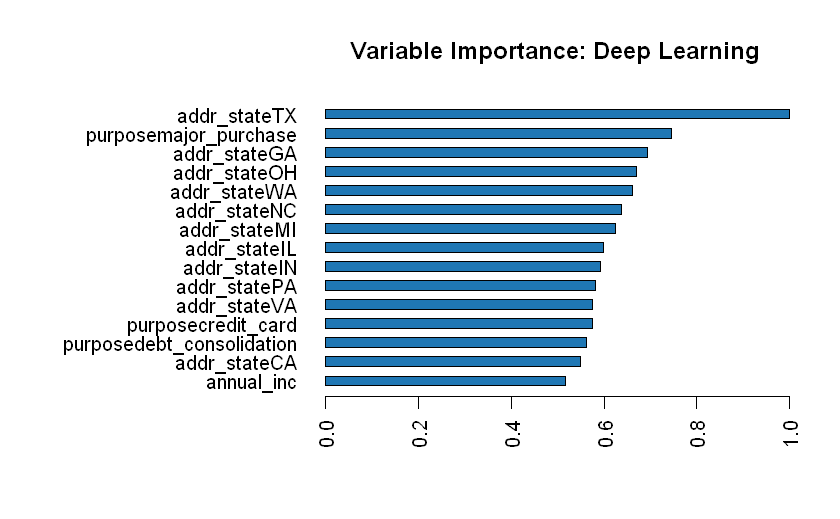

In [40]:
#select model 9 as our final model
best_nnet_model_id <- nnet.grid.perf@model_ids[[9]]
best_nnet <- h2o.getModel(best_nnet_model_id)

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_nnet_perf <- h2o.performance(model = best_nnet, 
                                 newdata = h2o_test)
#initialize dataframe for model performance comparison
model_performance <- data.frame(model = "neural network", accuracy = h2o.auc(best_nnet_perf))
model_performance

#variable importance plot
plot_width = 7
options(repr.plot.width= plot_width, repr.plot.height=plot_width * 0.618)
h2o.varimp_plot(best_nnet,num_of_features = 15)

### 4.B Naive Bayes

In [18]:
#set grid search parameters
nb.params <- list(laplace = c(1,5,10)) 

# Train and validate a grid of naive bayes
nb.grid <- h2o.grid("naivebayes", x = x, y = y,
                      grid_id = "nb.grid",
                      training_frame = h2o_train,
                      validation_frame = h2o_valid,
                      seed = 20070831,
                      hyper_params = nb.params)

  |======================================================================| 100%


Find the best model, the best model is model **2**

In [19]:
nb.grid.perf <- h2o.getGrid(grid_id = "nb.grid", 
                              sort_by = "auc", 
                              decreasing = TRUE)
print(nb.grid.perf)

H2O Grid Details

Grid ID: nb.grid 
Used hyper parameters: 
  -  laplace 
Number of models: 3 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by decreasing auc
  laplace       model_ids                auc
1    10.0 nb.grid_model_2  0.596158062025771
2     5.0 nb.grid_model_1 0.5961539286336517
3     1.0 nb.grid_model_0 0.5961539286336517


In [41]:
#select model 2 as our final model
best_nb_model_id <- nb.grid.perf@model_ids[[2]]
best_nb <- h2o.getModel(best_nb_model_id)

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_nb_perf <- h2o.performance(model = best_nb, 
                                  newdata = h2o_test)
#initialize dataframe for model performance comparison
model_performance <- rbind(model_performance,data.frame(model = "naive bayes", accuracy = h2o.auc(best_nb_perf)))
model_performance
# This model doesn't have variable importance, so we don't plot it

model,accuracy
neural network,0.6527453
naive bayes,0.5983807


### 4.C Random Forest

In [21]:
#set grid search parameters
rf.params <- list(ntrees = c(50,200),
                  nbins = c(20),
                  distribution = c("bernoulli","multinomial", "gaussian", "poisson")) 

# Train and validate a grid of random forest
rf.grid <- h2o.grid("randomForest", x = x, y = y,
                    grid_id = "rf.grid",
                    training_frame = h2o_train,
                    validation_frame = h2o_valid,
                    seed = 20070831,
                    hyper_params = rf.params)

  |======================================================================| 100%


The best model is: model no.**5**

In [22]:
rf.grid.perf <- h2o.getGrid(grid_id = "rf.grid", 
                             sort_by = "auc", 
                             decreasing = TRUE)
print(rf.grid.perf)

H2O Grid Details

Grid ID: rf.grid 
Used hyper parameters: 
  -  distribution 
  -  nbins 
  -  ntrees 
Number of models: 8 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by decreasing auc
  distribution nbins ntrees       model_ids                auc
1  multinomial    20    200 rf.grid_model_5 0.6830113861619366
2      poisson    20    200 rf.grid_model_7 0.6830113861619366
3     gaussian    20    200 rf.grid_model_6 0.6830113861619366
4    bernoulli    20    200 rf.grid_model_4 0.6830113861619366
5    bernoulli    20     50 rf.grid_model_0 0.6793552230520612
6      poisson    20     50 rf.grid_model_3 0.6793552230520612
7  multinomial    20     50 rf.grid_model_1 0.6793552230520612
8     gaussian    20     50 rf.grid_model_2 0.6793552230520612


model,accuracy
neural network,0.6527453
naive bayes,0.5983807
random forest,0.6741384


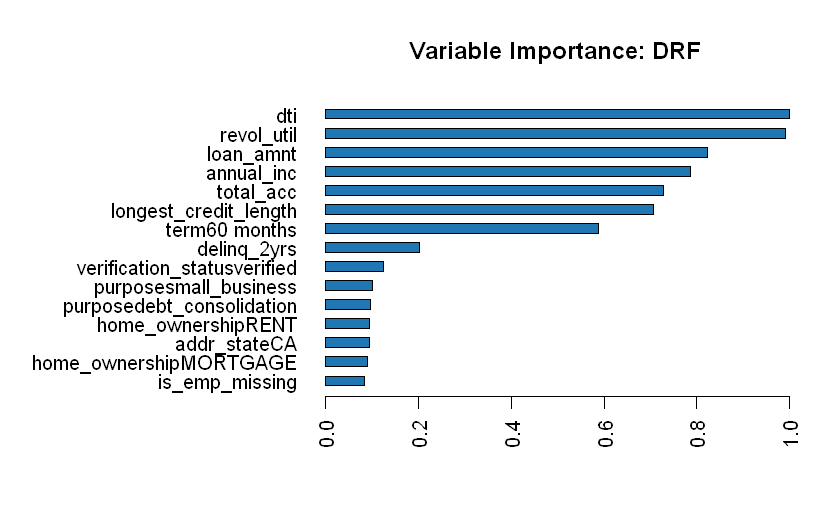

In [42]:
#select model 5 as our final model
best_rf_model_id <- rf.grid.perf@model_ids[[5]]
best_rf <- h2o.getModel(best_rf_model_id)

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_rf_perf <- h2o.performance(model = best_rf, 
                                 newdata = h2o_test)
#initialize dataframe for model performance comparison
model_performance <- rbind(model_performance,data.frame(model = "random forest", accuracy = h2o.auc(best_rf_perf)))
model_performance

#variable importance plot
plot_width = 7
options(repr.plot.width= plot_width, repr.plot.height=plot_width * 0.618)
h2o.varimp_plot(best_rf,num_of_features = 15)

### 4.D Gradient Boosting Machine

In [24]:
#set grid search parameters
gbm.params <- list(learn_rate = seq(0.01, 0.1),
                   max_depth = seq(3,5),
                   sample_rate = seq(0.8,1),
                   col_sample_rate = seq(0.2, 0.5),
                   ntrees = 200)

# Train and validate a grid of GBMs
gbm.grid <- h2o.grid("gbm", x = x, y = y,
                     grid_id = "gbm.grid",
                     training_frame = h2o_train,
                     validation_frame = h2o_valid,
                     seed = 20070831,
                     hyper_params = gbm.params)

  |======================================================================| 100%


The best model is: model no.**2**

In [25]:
gbm.grid.perf <- h2o.getGrid(grid_id = "gbm.grid", 
                             sort_by = "auc", 
                             decreasing = TRUE)
print(gbm.grid.perf)

H2O Grid Details

Grid ID: gbm.grid 
Used hyper parameters: 
  -  col_sample_rate 
  -  learn_rate 
  -  max_depth 
  -  ntrees 
  -  sample_rate 
Number of models: 3 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by decreasing auc
  col_sample_rate learn_rate max_depth ntrees sample_rate        model_ids
1             0.2       0.01         5    200         0.8 gbm.grid_model_2
2             0.2       0.01         4    200         0.8 gbm.grid_model_1
3             0.2       0.01         3    200         0.8 gbm.grid_model_0
                 auc
1 0.6796349881420536
2 0.6767847698278375
3 0.6732146468305327


model,accuracy
neural network,0.6527453
naive bayes,0.5983807
random forest,0.6741384
gradient boosting machine,0.6747441


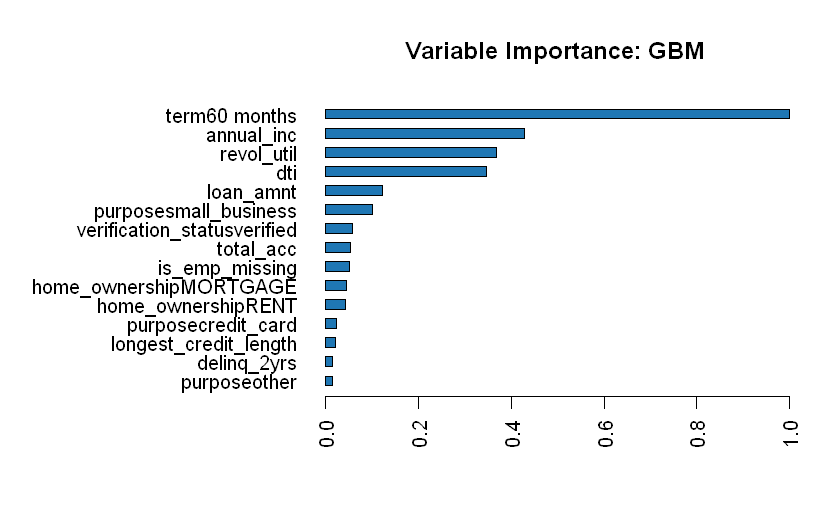

In [43]:
#select model 4 as our final model
best_gbm_model_id <- gbm.grid.perf@model_ids[[2]]
best_gbm <- h2o.getModel(best_gbm_model_id)

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_gbm_perf <- h2o.performance(model = best_gbm, 
                                 newdata = h2o_test)
#initialize dataframe for model performance comparison
model_performance <- rbind(model_performance,data.frame(model = "gradient boosting machine", accuracy = h2o.auc(best_gbm_perf)))
model_performance

#variable importance plot
plot_width = 7
options(repr.plot.width= plot_width, repr.plot.height=plot_width * 0.618)
h2o.varimp_plot(best_gbm,num_of_features = 15)

### 4.E Generalized Linear Model

In [27]:
# Train and validate glm
glm_fit <- h2o.glm(x = x, 
                    y = y, 
                    training_frame = h2o_train,
                    model_id = "glm_fit",
                    validation_frame = h2o_valid,
                    family = "binomial",
                    lambda_search = TRUE)

  |======================================================================| 100%


model,accuracy
neural network,0.6527453
naive bayes,0.5983807
random forest,0.6741384
gradient boosting machine,0.6747441
generalized linear model,0.6788212


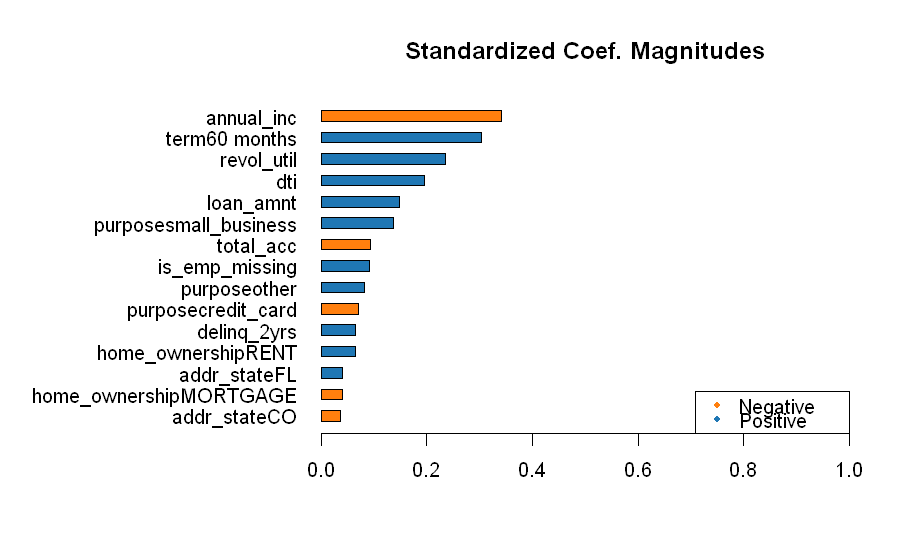

In [44]:
#model perforamance:
glm_perf <- h2o.performance(model = glm_fit,
                             newdata = h2o_test)
model_performance <- rbind(model_performance,data.frame(model = "generalized linear model", accuracy = h2o.auc(glm_perf) ))
model_performance

plot_width = 7.5
options(repr.plot.width= plot_width, repr.plot.height=plot_width * 0.618)
h2o.varimp_plot(glm_fit,num_of_features = 15)

### 4.F Model Performance Comparison

Overall, after testing differnt parameters, generalized linear model and tree based models have best performance.

In [45]:
ratio_bad <-as.data.frame(h2o_test) %>% summarise( accuracy = sum(bad_loan == "1")/n()) 
final_table <- rbind(model_performance,data.frame(model = "bad_loan ratio in test data" ,accuracy = ratio_bad))
final_table %>% arrange(desc(accuracy))

model,accuracy
generalized linear model,0.6788212
gradient boosting machine,0.6747441
random forest,0.6741384
neural network,0.6527453
naive bayes,0.5983807
bad_loan ratio in test data,0.1828119


Let's also compare variable importance graph:

In [35]:
plot_width = 10
options(repr.plot.width= plot_width, repr.plot.height=plot_width * 0.618)
perf_table <- rbind(rbind(cbind(model = "nnet",h2o.varimp(best_nnet)),
    cbind(model = "rf",h2o.varimp(best_rf)),
    cbind(model = "gbm",h2o.varimp(best_gbm))) %>% 
        select(model,variable,relative_importance),
    cbind(model = "glm",h2o.varimp(glm_fit)) %>% 
        select(model,names,coefficients) %>% 
        rename(variable = names,relative_importance = coefficients))
#make plot
models <- unique(perf_table$model)
plot_data <- perf_table %>%  
        group_by(model) %>%
        mutate(rank = min_rank(desc(relative_importance))) %>%
        filter(rank <= 15) %>%
        ungroup() 
p1 <- list(); p2 <- list(); p3 <- list(); p4 <- list()
for(i in 1: length(models)){
    assign(str_c("p",i),plot_data %>%
           filter(model == models[i]) %>%
           mutate(variable = fct_reorder(variable,desc(rank))) %>%
           ggplot(aes(x = variable, y = relative_importance)) +
            geom_col(fill = "skyblue3") +
           labs(title = models[i]) +
            coord_flip()) 
}

In [31]:
#plot in the same graph
# Multiple plot function
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

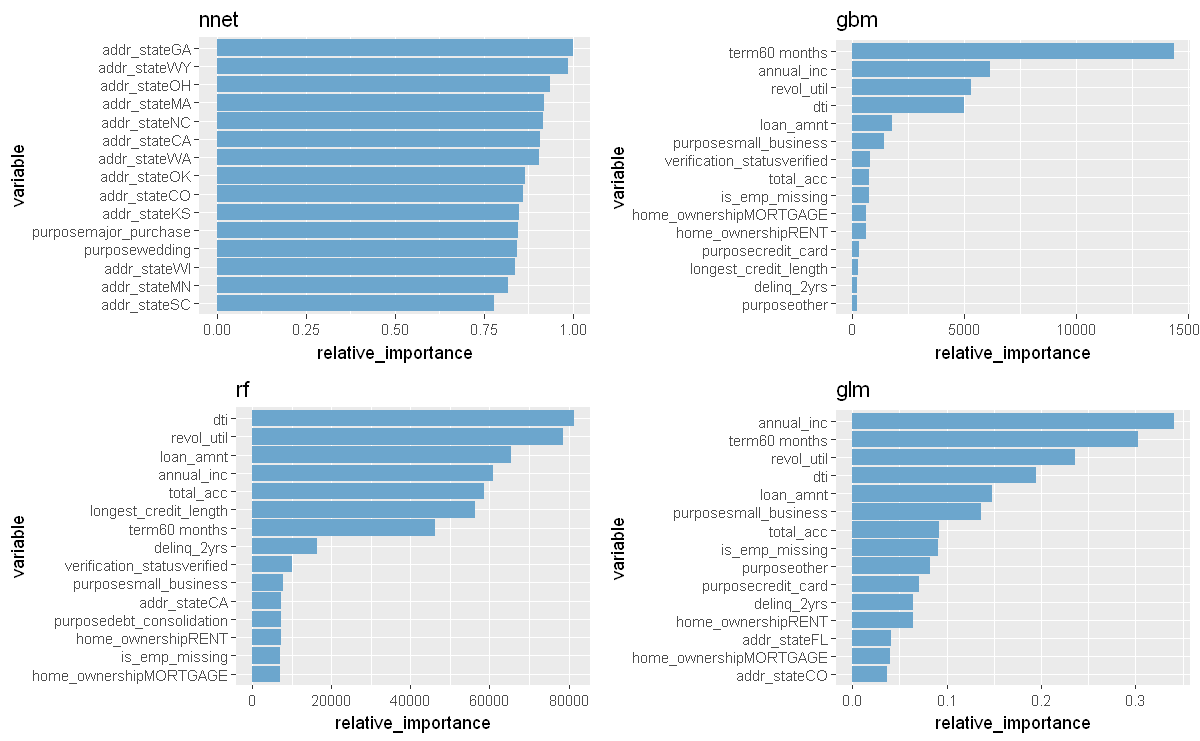

In [36]:
multiplot(p1, p2, p3, p4, cols=2)

## 5. Summary

The performance of top 3 models(generalized linear model,gradient boosting machine,random forest) are very close. 

## 6.Reference
[h2o documents](https://h2o-release.s3.amazonaws.com/h2o/rel-ueno/2/docs-website/h2o-docs/welcome.html)  
[h2o tutorial](https://github.com/h2oai/h2o-tutorials)  
[caret documents](http://topepo.github.io/caret/index.html)  
http://www.cookbook-r.com/Graphs/Multiple_graphs_on_one_page_(ggplot2)/